#### 5

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,1)
var_sarpdq   <-  c(2,0,1)
var_drift   <-  TRUE
var_constant   <-  TRUE

var_char  <-  c(2,1)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2968.783 3016.091 3016.090 3095.627 3074.818 3137.873 3128.164 3195.811
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3023.835 3085.051 3101.512 3145.712 3106.592 3168.773 3170.249 3228.061
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3067.862 3143.776 3138.026 3220.446 3182.952 3248.896 3224.882 3288.791
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3195.224 3239.329 3240.098 3294.665 3250.864 3295.828 3284.349 3342.051
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3382.361 3440.004 3412.750 3466.703 3424.836 3471.508 3439.138 3494.014
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3381.931 3300.888 3368.632 3340.012 3412.677 3370.148 3444.701 3420.275
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
df_acc

ME,RMSE,MAPE,Iteration
-46.80434,64.24111,1.683795,1
-30.60997,36.88612,1.071658,5
44.83393,61.78483,1.428066,9
63.59360,68.14802,1.902082,13
-49.33932,64.61809,1.739157,17
83.32252,89.97991,2.391756,20


In [13]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3383.099 3440.919 3412.570 3466.483 3425.701 3472.491 3438.824 3493.713

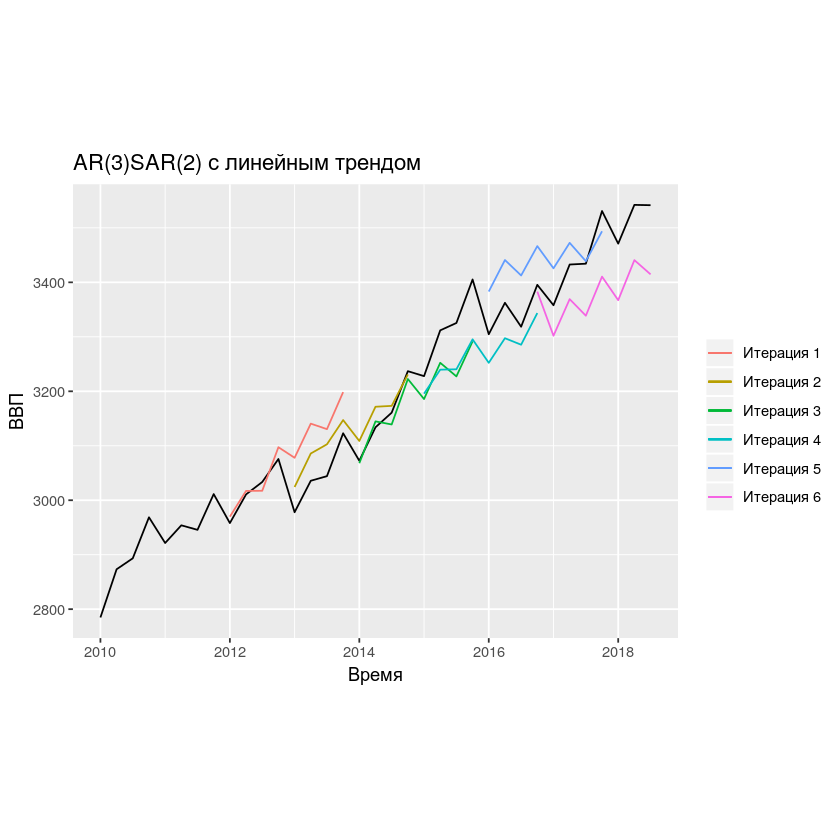

In [14]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [15]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
10.832738 64.276345  1.702752 10.833333

In [16]:
df_mean_acc <- readRDS("df_mean_acc.rds")
rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [17]:
df_mean_acc[2,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.976,16758.99
3 level,64.27635,NA,NA
2 level (state),NA,NA,NA
2 level (type),NA,NA,NA
2 level (clusetered),NA,NA,NA


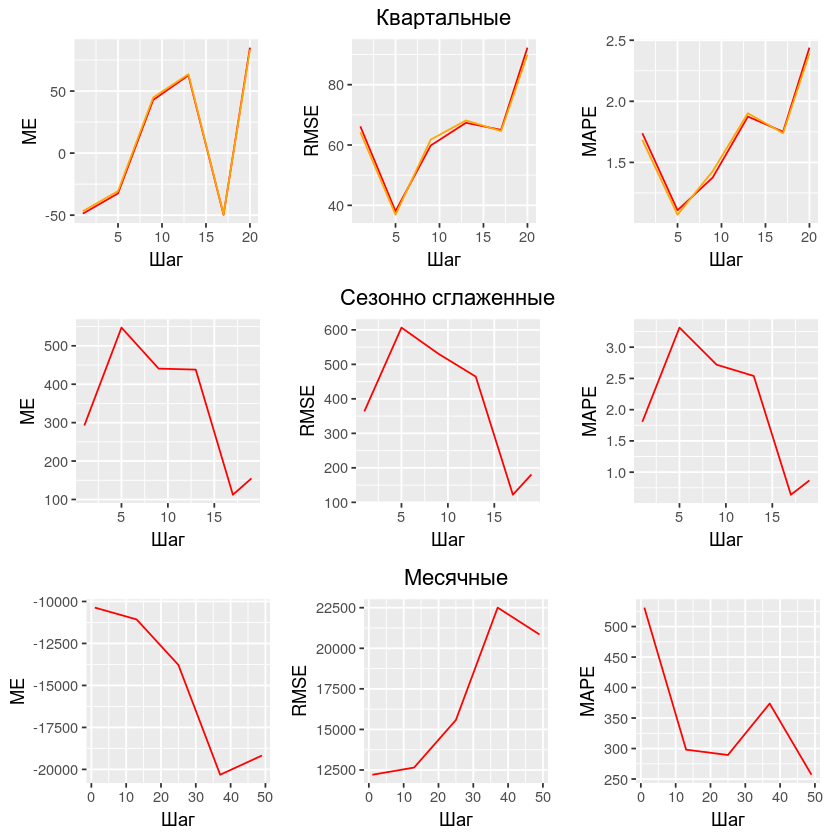

In [18]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [19]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_state.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [20]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

# var_arpdq   <-  c(3,0,0)
# var_sarpdq   <-  c(2,0,0)
# var_char  <-  c(2,1)

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(y)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2968.842 3016.164 3016.181 3095.735 3074.960 3137.957 3128.158 3195.785
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3023.859 3085.097 3101.569 3145.773 3106.703 3168.927 3170.384 3228.222
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“seasonal MA part of model is not invertible”Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3067.880 3143.826 3138.040 3220.493 3183.023 3248.953 3224.820 3288.732
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3195.280 3239.421 3240.173 3294.748 3250.999 3295.997 3284.463 3342.205
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3382.455 3440.141 3412.800 3466.742 3424.925 3471.613 3439.117 3493.996
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3382.560 3301.447 3368.046 3338.359 3409.171 3364.997 3437.980 3412.645
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
-46.86988,64.28292,1.685224,1
-30.70366,36.94401,1.073407,5
44.81728,61.79650,1.427919,9
63.48370,68.04756,1.898792,13
-49.39877,64.68790,1.741058,17
86.33005,93.71004,2.477124,20


In [27]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3383.099 3440.919 3412.570 3466.483 3425.701 3472.491 3438.824 3493.713

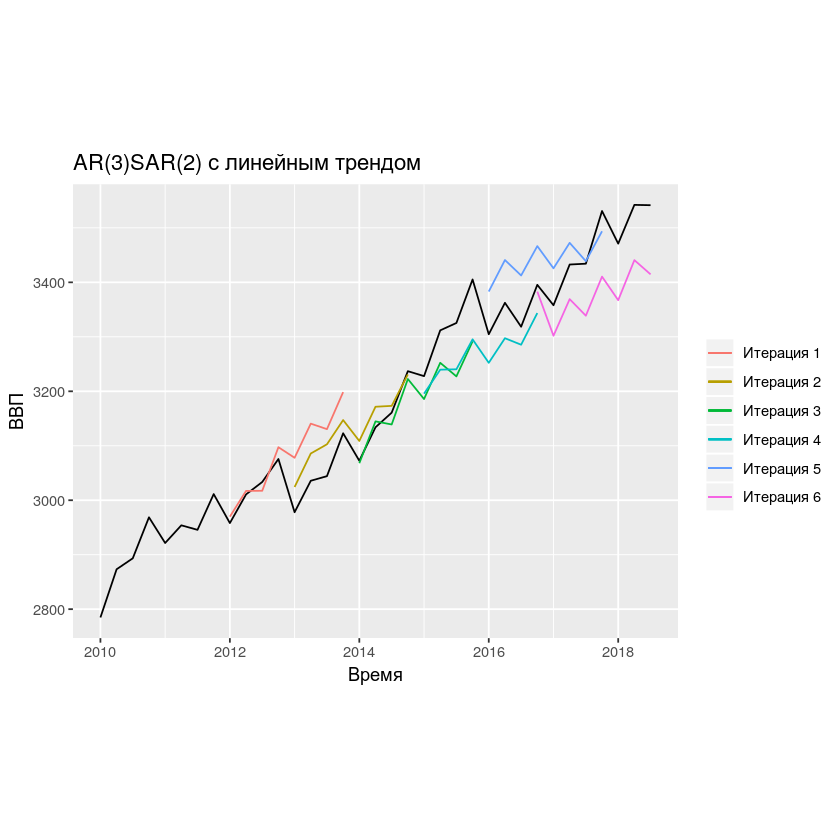

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
11.276453 64.911491  1.717254 10.833333

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.976,16758.99
3 level,64.27635,NA,NA
2 level (state),64.91149,NA,NA
2 level (type),NA,NA,NA
2 level (clusetered),NA,NA,NA


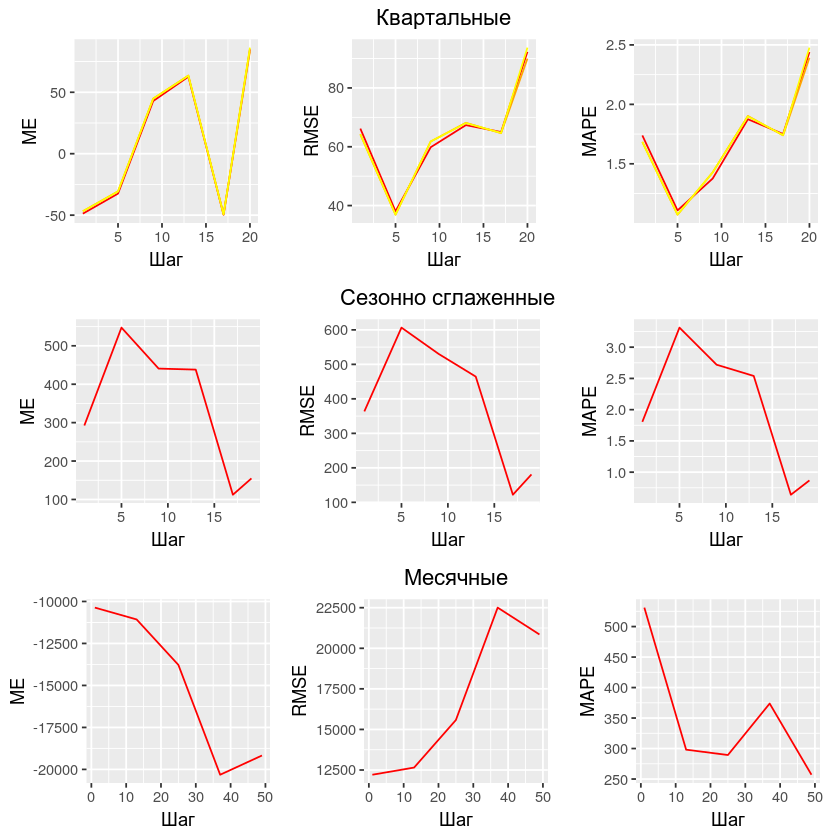

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_type.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [34]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [35]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

# var_arpdq   <-  c(3,0,0)
# var_sarpdq   <-  c(2,0,0)
# var_char  <-  c(2,1)

In [36]:
75-69

[1] 6

In [37]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [38]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2968.548 3017.109 3018.851 3098.006 3075.737 3139.007 3131.083 3199.128
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3023.512 3084.832 3101.565 3147.102 3106.865 3169.750 3172.400 3230.447
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3066.875 3143.042 3138.799 3220.956 3181.303 3247.620 3225.743 3289.795
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3193.717 3238.310 3239.585 3294.855 3249.386 3295.228 3285.195 3343.353
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3380.573 3438.082 3411.278 3464.780 3420.838 3467.972 3437.154 3491.899
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3381.399 3299.103 3365.639 3336.934 3407.555 3361.704 3434.905 3411.293
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [39]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [40]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [41]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [42]:
df_acc

ME,RMSE,MAPE,Iteration
-48.58092,65.61205,1.719116,1
-31.44589,37.08375,1.079479,5
45.02157,61.63589,1.428412,9
63.94096,68.46108,1.912836,13
-46.99715,62.90119,1.685136,17
88.41403,95.68938,2.537275,20


In [43]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3383.099 3440.919 3412.570 3466.483 3425.701 3472.491 3438.824 3493.713

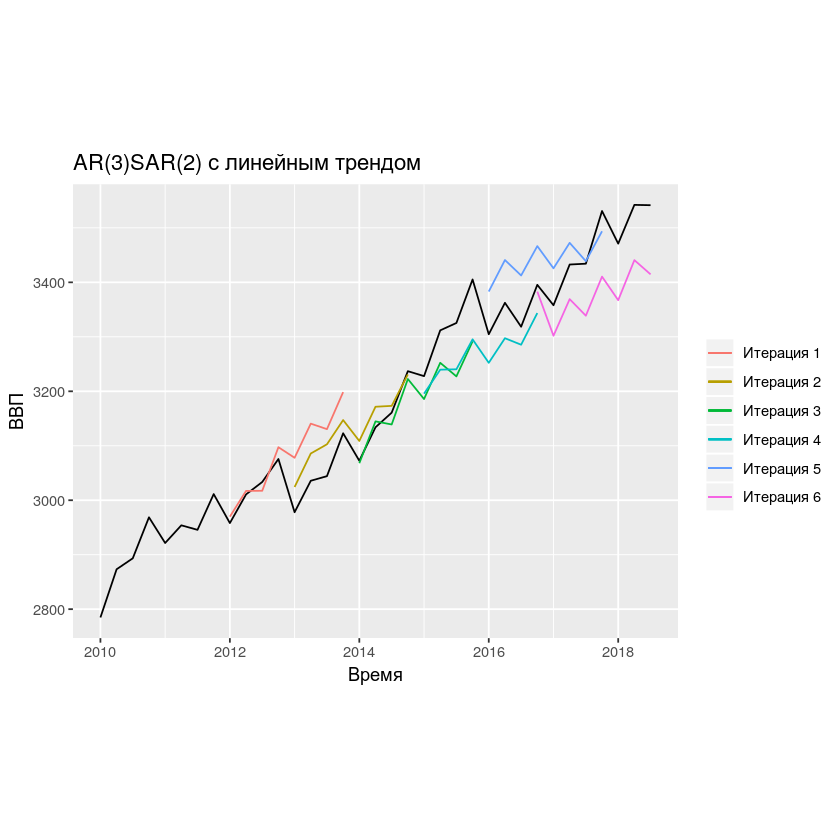

In [44]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [45]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
11.725435 65.230559  1.727042 10.833333

In [46]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [47]:
df_mean_acc[4,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.976,16758.99
3 level,64.27635,NA,NA
2 level (state),64.91149,NA,NA
2 level (type),65.23056,NA,NA
2 level (clusetered),NA,NA,NA


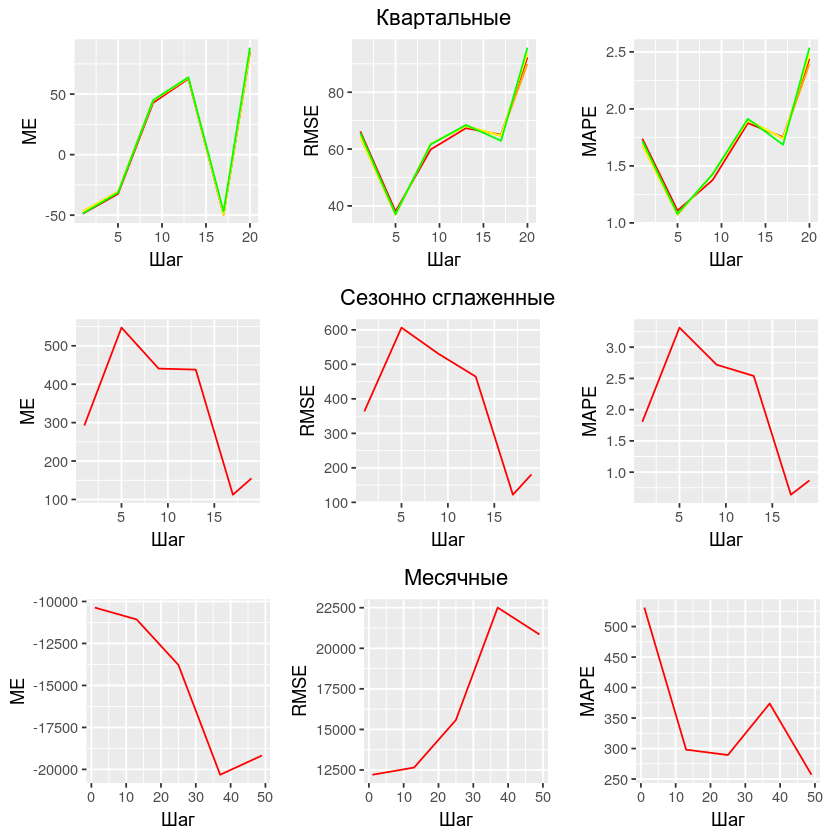

In [48]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [49]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [50]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [51]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0



In [52]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [53]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2969.516 3016.934 3016.993 3096.557 3076.259 3139.435 3129.645 3197.397
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3023.899 3085.199 3101.810 3146.260 3107.112 3169.490 3170.998 3228.666
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3067.446 3143.627 3137.953 3220.361 3182.740 3248.784 3224.706 3288.465
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Warning message in predict.Arima(object, n.ahead = h, newxreg = xreg):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3195.619 3239.768 3240.482 3295.181 3251.684 3296.752 3285.051 3342.774
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3382.737 3440.322 3412.823 3466.706 3425.349 3471.694 3439.089 3493.797
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3382.470 3301.025 3367.543 3337.784 3409.136 3365.245 3438.526 3413.695
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [54]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [55]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [56]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [57]:
df_acc

ME,RMSE,MAPE,Iteration
-47.98941,65.32240,1.715365,1
-31.06604,37.17415,1.081552,5
45.02776,61.93840,1.432890,9
62.98086,67.59379,1.883720,13
-49.48982,64.83172,1.745225,17
86.30242,93.57552,2.476542,20


In [58]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3383.099 3440.919 3412.570 3466.483 3425.701 3472.491 3438.824 3493.713

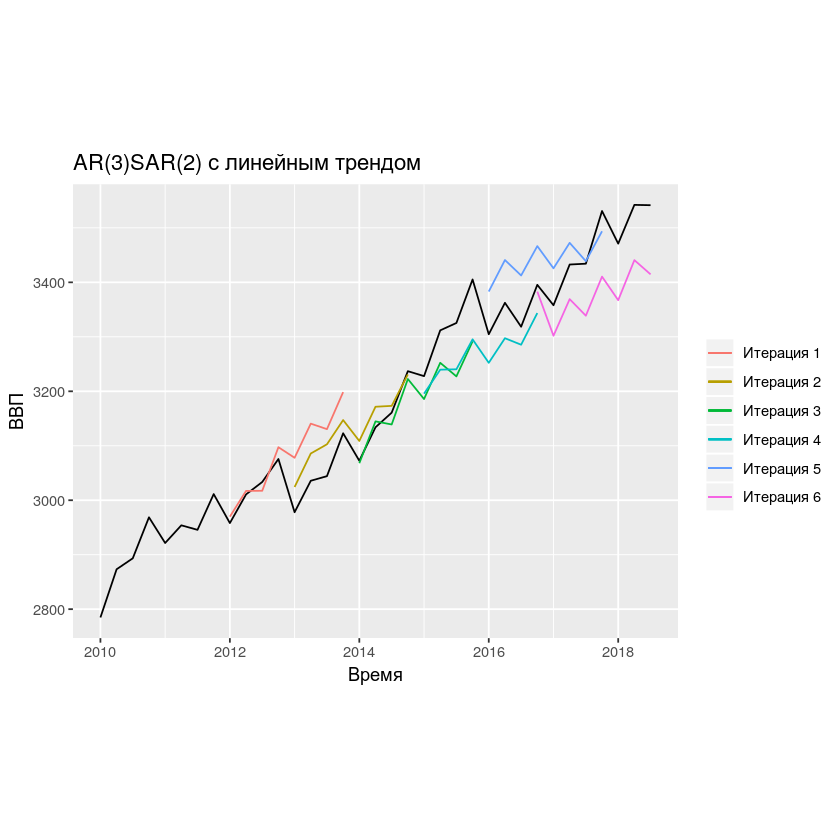

In [59]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [60]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
10.960962 65.072662  1.722549 10.833333

In [61]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [62]:
df_mean_acc[5,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.976,16758.99
3 level,64.27635,NA,NA
2 level (state),64.91149,NA,NA
2 level (type),65.23056,NA,NA
2 level (clusetered),65.07266,NA,NA


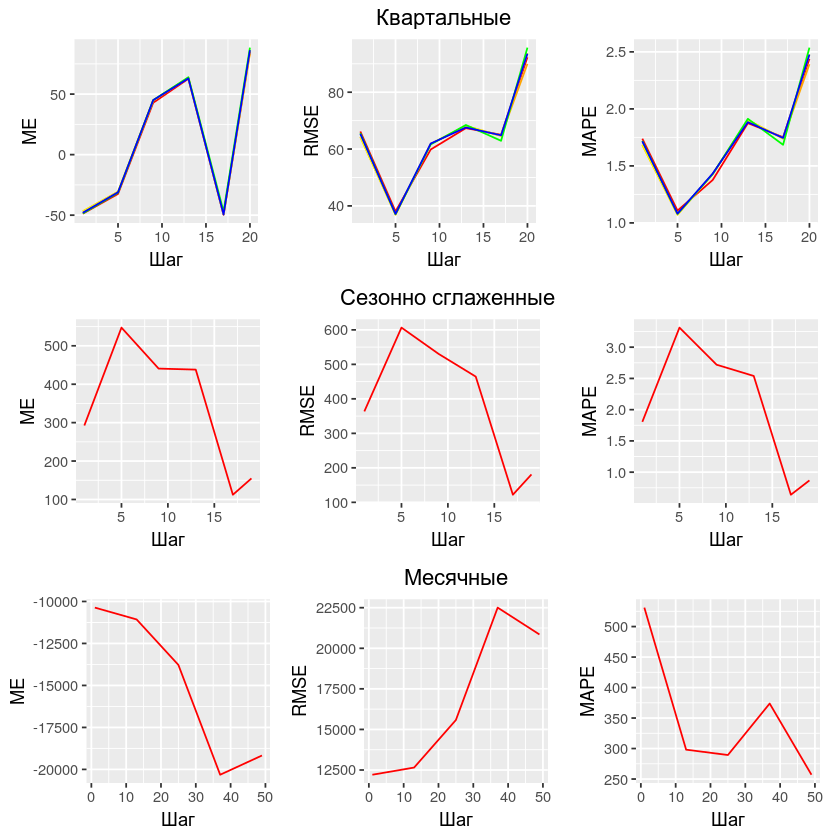

In [63]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [64]:
saveRDS(df_mean_acc, "df_mean_acc.rds")

In [65]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.78726,377.976,16758.99
3 level,64.27635,NA,NA
2 level (state),64.91149,NA,NA
2 level (type),65.23056,NA,NA
2 level (clusetered),65.07266,NA,NA


In [66]:


saveRDS(plots_test_all, "plots_test_not_all.rds")